# Feature Extraction using ORB

## 💡 1. Introduction 
There is an old saying that you shouldn't judge a book by its cover, but with modern technology this might actually be possible. In order for us to recognize covers we need to perform feature extractions. In this document we are going to look at the ORB approach and see how well it performs at solving this problem.

<img src="../../resources/box-art-recognition.png" alt="concept" align="left" width="480"/>

## 📚 2. Preparations
In order to perform any kind of image processing we need to use a lot of algorithms. Luckily scikit-image has these functionalities built in for us to use. Its available free of charge and free of restriction. https://scikit-image.org/docs/dev/license.html

Furthermore we use some OS level features for file directory navigation and matplotlib.pyplot to create some nice visualisations if needed.

In [1]:
import os
import os.path

from skimage import io
from skimage import transform
from skimage.color import rgb2gray

from skimage.feature import ORB
from skimage.feature import plot_matches
from skimage.feature import match_descriptors

import math
import matplotlib.pyplot as plt

## ⚙️ 3. Settings

In [2]:
## SETTINGS FOR QUERY_IMAGES
QUERY_IMAGES_PATH = '../../data/samples/query-images'
QUERY_IMAGES_HEIGHT = 256

## SETTINGS FOR TARGET_IMAGES
TARGET_IMAGES_PATH = '../../data/samples/target-images'
TARGET_IMAGES_HEIGHT = 256

## NUMBER OF KEYPOINTS (FEATURES)
## TO EXTRACT FROM AN IMAGE
N_KEYPOINTS = 1500

## SETTINGS FOR MATCH_DESCRIPTOR
MATCH_DESCRIPTOR_RATIO = 0.80
MATCH_DESCRIPTOR_THRESHOLD = 30
MATCH_DESCRIPTOR_METRIC = 'hamming'

## 🎨 4. Spectating the images
First let’s take a glance at all the images that are available in the sample set. I've taken several pictures with the camera of my mobile phone. I will be referring to these images as query-images because these images contain the product we are looking for (thus querying).

Naturally we also need the images that are in the query-images, which I will be referring to as the target-images. It's the actual image of the box art we are looking for (in high quality).

In [3]:
def load_image(path):
    return io.imread(path)

In [4]:
def list_files(path):
    fnames = os.listdir(path)
    abspath = lambda x: os.path.join(path, x)
    return [abspath(file) for file in fnames]

In [5]:
def plot_images_in_dir(path):
    fnames = list_files(path)
    for idx, (abspath) in enumerate(fnames):
        plt.subplot(1, len(fnames), idx+1)
        plt.imshow(load_image(abspath))

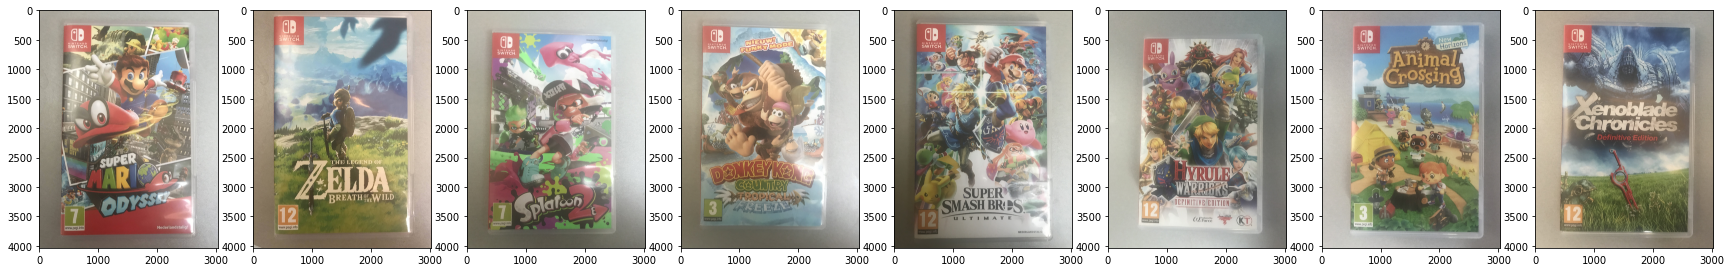

In [6]:
plt.figure(figsize=(30,20))
plot_images_in_dir(QUERY_IMAGES_PATH)

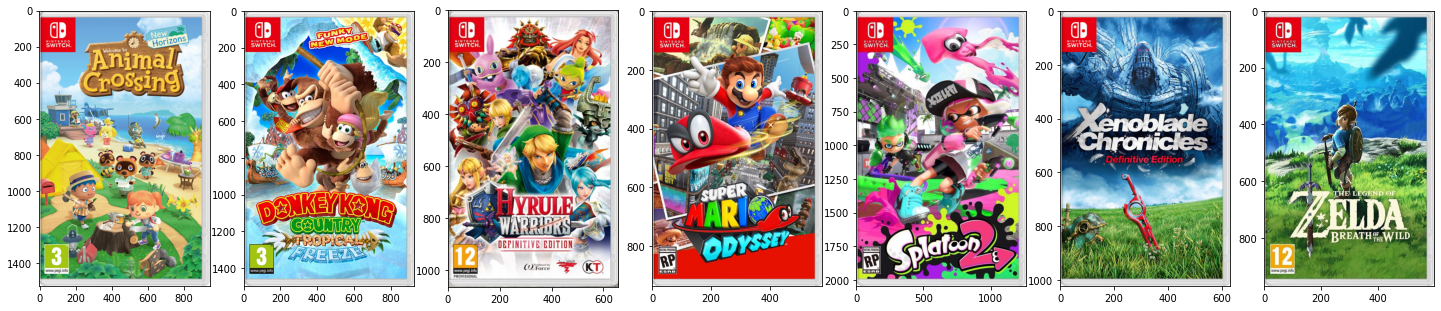

In [7]:
plt.figure(figsize=(25,15))
plot_images_in_dir(TARGET_IMAGES_PATH)

Because the query-images were all made with the same camera and settings, they all have the same resolution. This is not the case for the target-images, which vary widely in size. Although ORB is rotation and scale-invariant it’s not as robust as SIFT in the scale department. Therefore, it’s still a good idea to have all the images with (roughly) the same width and height.

In [8]:
# This functions resizes an image,
# aspect ratio is maintained if either 
# width or height has not been specified

def resize_image(image, width=None, height=None):

    # grab the dimensions
    dim = (height, width)
    h, w = image.shape[:2] 
    
    # if width is None
    # auto-calculate the width
    if width is None:
        r = height / float(h)
        dim = (height, int(w * r))   
    
    # if height is None
    # auto calculate the height
    elif height is None:
        r = width / float(w)
        dim = (int(h * r), width)
        
    # return resized image
    return transform.resize(image, dim)

## 🔎 5. Feature Extraction

In [9]:
## This function extracts important
# features from an image using ORB method

def extract_from_image(image):
    extractor = ORB(n_keypoints=N_KEYPOINTS)
    extractor.detect_and_extract(rgb2gray(image))
    return extractor.keypoints, extractor.descriptors

In [10]:
## This function loads an image from
# a path and preprocesses it before 
# returning the image with the extracted features

def load_and_extract_image(
    path, preprocessor=lambda x: x):
    image = preprocessor(load_image(path))
    return image, *extract_from_image(image)

In [11]:
# The preprocessor will resize the 
# images before extracting the features

QUERY_IMAGE_PREPROCESSOR = lambda image: resize_image(
image, height=QUERY_IMAGES_HEIGHT)

TARGET_IMAGE_PREPROCESSOR = lambda image: resize_image(
image, height=TARGET_IMAGES_HEIGHT)

In [12]:
# We load and extract all images that
# can be found in the QUERY_IMAGES_PATH
# and preprocess them to a smaller image size

QUERY_IMAGES = [(
    load_and_extract_image(f, QUERY_IMAGE_PREPROCESSOR)) 
    for f in list_files(QUERY_IMAGES_PATH)]

TARGET_IMAGES = [(
    load_and_extract_image(f, TARGET_IMAGE_PREPROCESSOR)) 
    for f in list_files(TARGET_IMAGES_PATH)]

## 🧑‍🤝‍🧑 6. Match Descriptors

In [13]:
def cross_match(query_desc, target_desc):
    return match_descriptors(
        query_desc, target_desc,
        metric=MATCH_DESCRIPTOR_METRIC,
        max_ratio=MATCH_DESCRIPTOR_RATIO)

In [14]:
def match_count(cross_match):
    t_data, t_kp, matches = cross_match
    return len(matches)

In [15]:
predictions = []
for q_data, q_kp, q_desc in QUERY_IMAGES:
    
    matches = []
    for t_data, t_kp, t_desc in TARGET_IMAGES:
        r = cross_match(q_desc, t_desc)
        matches.append((t_data, t_kp, r))
        
    matches.sort(key=match_count, reverse=True)
    predictions.append((q_data, q_kp, matches))

## 📈 7. Visualisations

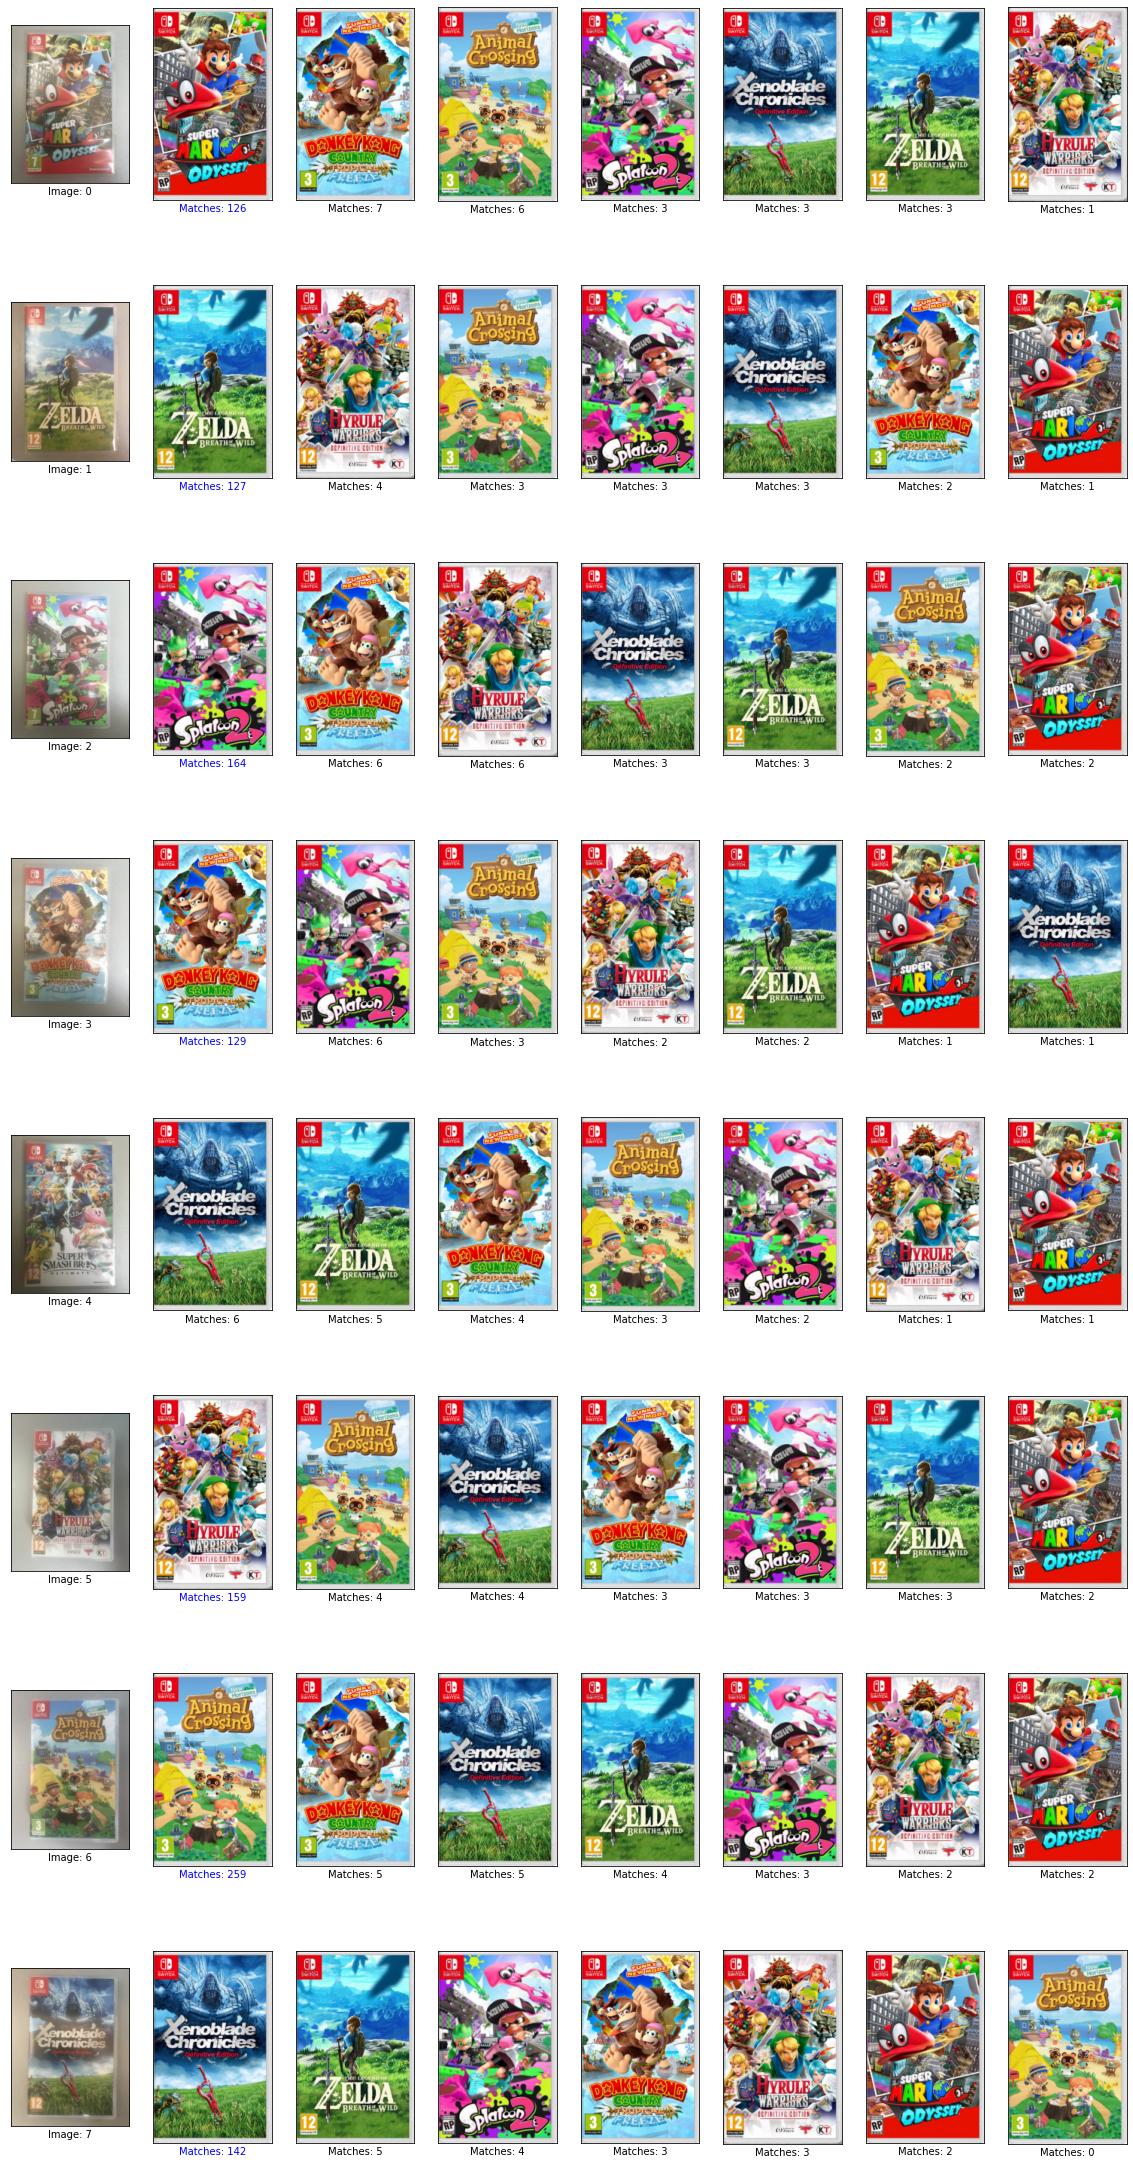

In [16]:
nrows = len(QUERY_IMAGES)
ncols = len(TARGET_IMAGES) + 1

plt.figure(figsize=(20,40))
for y, (q_data, q_keypoints, cross_match) in enumerate(predictions):
    plt.subplot(nrows, ncols, y * ncols + 1)
    plt.imshow(q_data)
    plt.xlabel(f'Image: {y}')
    plt.xticks([])
    plt.yticks([])
    
    for x, (t_data, t_keypoints, matches) in enumerate(cross_match):
        plt.subplot(nrows, ncols, y * ncols + 1 + x + 1)
        plt.xlabel(f'Matches: {len(matches)}', color='b' if len(matches) >= MATCH_DESCRIPTOR_THRESHOLD else 'k')
        plt.imshow(t_data)
        plt.xticks([])
        plt.yticks([])

plt.show()

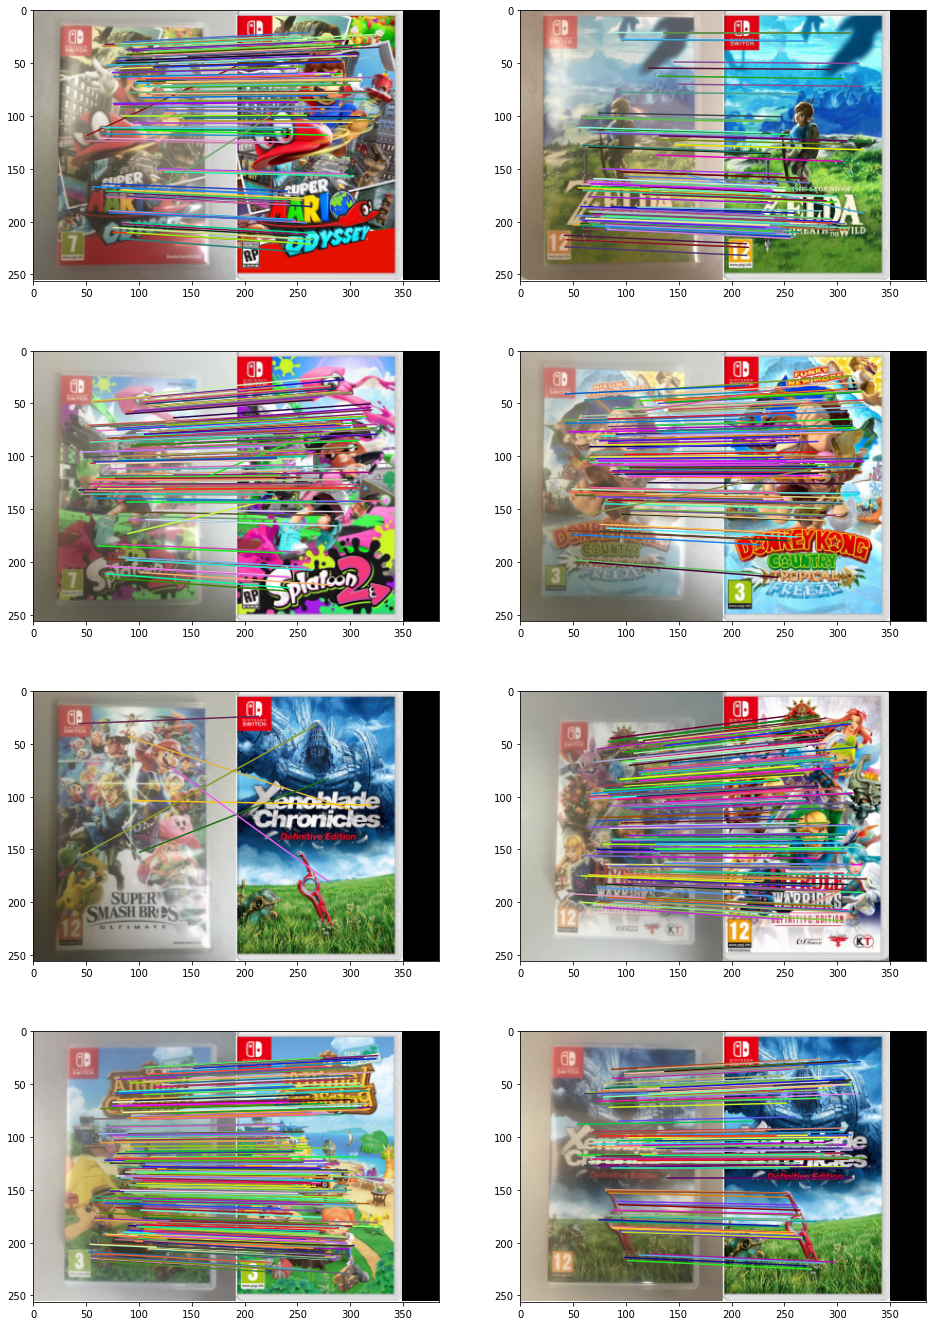

In [17]:
ncols = 2
nrows = math.ceil(len(QUERY_IMAGES) / ncols)

fig = plt.figure(figsize=(16,24))
axs = [fig.add_subplot(nrows, ncols, r * ncols + c + 1) 
       for r in range(0, nrows) for c in range(0, ncols)]

for idx, (q_data, q_keypoints, cross_match) in enumerate(predictions):
    
    # Matches are sorted by their length,
    # So the first entry has the most matches
    t_data, t_keypoints, matches = cross_match[0]
    
    # Plot the matches between the query images and best matching target image
    plot_matches(axs[idx], q_data, t_data, q_keypoints, t_keypoints, matches, only_matches=True)